In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from torch import nn
import torch.nn.functional as F
from scipy.stats import linregress
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import json

In [19]:
def moving_average(data, window_size=15):
    X_smooth = np.zeros(data.shape)
    for i,channel in enumerate(data):
        X_smooth[i] = np.convolve(channel, np.ones(window_size)/window_size, mode='same')
    return torch.from_numpy(X_smooth).to(torch.float32)
def warp_time(data, label, max_scale=1.5):
    data = data.numpy()

    L = data.shape[1]
    scale = np.random.uniform(1, max_scale)
    new_L = int(L * scale)
    orig_t = np.linspace(0, 1, L)
    new_t = np.linspace(0, 1, new_L)

    warped = np.zeros((data.shape[0], new_L))
    for i, channel in enumerate(data):
        warped[i] = np.interp(new_t, orig_t, channel)
    
    # label = torch.from_numpy(np.interp(new_t, orig_t, label)).to(torch.float32)
    # label = label * scale

    # randomly crop to original length
    if new_L > L:
        start_idx = np.random.randint(0, new_L - L)
        warped = warped[:, start_idx:start_idx + L]
        # label = label[start_idx:start_idx + L]
        # label = label - (start_idx / L)

    return torch.from_numpy(warped).to(torch.float32), label

def scale(data, low=0.6, high=1.4):
    return data*np.random.uniform(low, high)

def segment_y(y, t=40, label_end=False):
    end_rep_markers = torch.where(torch.diff(y) < 0)[0]
    y = torch.zeros_like(y)
    starts = (end_rep_markers - t).clamp(0)
    ends = (end_rep_markers + t).clamp(0, y.shape[0])
    for start,end in zip(starts, ends):
        y[start: end] = 1
    
    # when using segment_y for entire session: make last t values 1 - this is the end of the last rep
    if label_end:
        y[-t:] = 1
    return y
class IMUDataset(Dataset):
    def __init__(self, df, winsize=250, stride=50, transform=None, aug=False):
        self.X = torch.from_numpy(df[['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].values)
        self.y = torch.from_numpy(df['rir'].values).to(torch.float32)
        if transform is not None:
            self.X = transform(self.X)
        self.X = self.X.transpose(0, 1).to(torch.float32)
        self.winsize = winsize
        self.stride = stride
        self.len = (self.X.shape[1] - winsize) // stride + 1
        self.aug = aug

        # for segmentation
        # self.y = segment_y(self.y, label_end=True)
    def __len__(self):
        return self.len
    def __getitem__(self, i):
        if i >= self.len:
            raise IndexError
        start = i * self.stride
        end = start + self.winsize
        y = self.y[start:end]#.mean()

        # FOR REGRESSION: y = y.mean() (single value)
        y = y.mean().unsqueeze(0)

        # FOR BINARY: 1 if y is last rep (< 1.5), 0 if not (single value)
        # y = torch.Tensor([1.0 if y.mean() < 1.5 else 0.0])

        # FOR SEGMENTATION: if y changes during window, y = 1 at that point. everywhere else is 0 (<winsize> values)
        # y = segment_y(y)

        # FOR SEGMENTATION REGRESSION: y = time when y changes (single value)
        # diff = torch.diff(y)
        # y = torch.diff(y).argmin().unsqueeze(0) / self.winsize if diff.min() < 0 else torch.Tensor([-1])
        
        X = self.X[:, start:end]
        X = moving_average(X)
        if self.aug:
            X,y = warp_time(X, y)
            X = scale(X)
        return X, y

In [20]:
HZ = 100
in_channels = 6
df = pd.read_csv('../data/data.csv')
session_ids = df['session_id'].unique()
print(len(session_ids))
train_ids, val_ids = train_test_split(session_ids, test_size=0.2, random_state=42)

df[['acc_x', 'acc_y', 'acc_z']] = (df[['acc_x', 'acc_y', 'acc_z']] / 2.0).clip(-1, 1)           # normalize accelerometer data from [-2g, 2g] to [-1, 1]
df[['gyr_x', 'gyr_y', 'gyr_z']] = (df[['gyr_x', 'gyr_y', 'gyr_z']] / 250.0).clip(-1, 1)         # normalize gyroscope data from [-250dps, 250dps] to [-1, 1]

# winsize_t = 5 # seconds
# stride_t = 0.01 # seconds
# winsize = int(winsize_t * HZ)
# stride = int(stride_t * HZ)
winsize = 1024
stride = 2
print(winsize, stride)

train = df.loc[df['session_id'].isin(train_ids), ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].values
# norm = torch.from_numpy(train.mean(axis=0)), torch.from_numpy(train.std(axis=0))

# def transform(x):
    # return (x - norm[0]) / norm[1]
transform = None

train_dataset = ConcatDataset([IMUDataset(df[df['session_id'] == session_id], winsize, stride, transform, aug=True) for session_id in train_ids])
val_dataset = ConcatDataset([IMUDataset(df[df['session_id'] == session_id], winsize, stride, transform, aug=False) for session_id in val_ids])

len(train_dataset), len(val_dataset)

72
1024 2


(72777, 19059)

In [21]:
class ResBlock(nn.Module):
    # One layer of convolutional block with batchnorm, relu and dropout
    def __init__(
            self, in_channels, out_channels,
            kernel_size=3, stride=1, dropout=0.0,
        ):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(
                in_channels, out_channels, 
                kernel_size=kernel_size, stride=stride, padding=kernel_size // 2,
            ),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.skip = nn.Conv1d(
            in_channels, out_channels, kernel_size=1, stride=stride
        ) if in_channels != out_channels or stride > 1 else nn.Identity()
    def forward(self, x):
        return self.block(x) + self.skip(x)
    
class DepthBlock(nn.Module):
    # "depth" number of ConvBlocks with downsample on the first block
    def __init__(
            self, depth, in_channels, out_channels,
            kernel_size=3, downsample_stride=2, 
            dropout=0.0
    ):
        super().__init__()
        self.blocks = nn.Sequential(*[
            ResBlock(
                in_channels=in_channels if i == 0 else out_channels, 
                out_channels=out_channels,
                kernel_size=kernel_size, 
                stride=downsample_stride if i == 0 else 1,
                dropout=dropout
            )
            for i in range(depth)
        ])
    def forward(self, x):
        return self.blocks(x)
 
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.width = config['width']
        self.depth = config['depth']
        self.stem_out_c = config['stem_out_c']
        self.stem_kernel = config['stem_kernel']
        self.dropout = config['dropout']

        if len(self.width) != len(self.depth):
            raise ValueError('Width and depth must have the same length')
        self.conv_out_channels = self.stem_out_c if len(self.width) == 0 else self.width[-1]

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels, self.stem_out_c, kernel_size=self.stem_kernel, padding=self.stem_kernel // 2),
            nn.BatchNorm1d(self.stem_out_c),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            *[DepthBlock(
                depth=self.depth[i],
                in_channels=self.stem_out_c if i == 0 else self.width[i-1], 
                out_channels=self.width[i],
                dropout=self.dropout, 
            ) for i in range(len(self.width))]
        )
    def forward(self, x):
        return self.encoder(x)

class ConvNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.encoder = Encoder(config)
        self.ap = nn.AdaptiveAvgPool1d(1)
        # self.fc = nn.Linear(512, winsize // 2)
        self.fc = nn.Linear(self.encoder.conv_out_channels, 1)
    def forward(self, x):
        x = self.encoder(x)
        # x = self.conv(x)
        x = self.ap(x).squeeze(-1)
        x = self.fc(x)
        # x = torch.repeat_interleave(x, 2, dim=1)
        return x
    def freeze(self, stop_idx=None):
        if stop_idx is None:
            stop_idx = len(self.encoder.encoder)
        for block in self.encoder.encoder[:stop_idx]:
            for param in block.parameters():
                param.requires_grad = False
    def get_optimizer(self, lr, weight_decay=1e-4, betas=(0.9, 0.999)):
        # AdamW optimzer - apply weight decay to linear and conv weights
        # but not to biases and batchnorm layers
        params = self.named_parameters()
        decay_params = [p for n,p in params if p.dim() >= 2]
        no_decay_params = [p for n,p in params if p.dim() < 2]
        optimizer = torch.optim.AdamW([
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': no_decay_params, 'weight_decay': 0.0}
        ], betas=betas, lr=lr)
        return optimizer

In [22]:
config = {
    'stem_out_c': 128,
    'depth': [2, 2, 1, 2, 1, 1],
    'width': [64, 64, 256, 256, 64, 256],
    'stem_kernel': 7,
    'learning_rate': 0.005377128323229521,
    'weight_decay': 0.00073713587550061,
    'dropout': 0.1718645168344513,
    'batch_size': 128,
    'device': 'cuda:0'
}

In [23]:
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=128, shuffle=False)
device = 'cuda'
model = ConvNet(config).to(device)
# model.freeze(-1)
criterion = nn.MSELoss()
optimizer = model.get_optimizer(lr=3e-4)
print(sum(p.numel() for p in model.encoder.parameters()))
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

739840
740097


In [28]:
X,y = next(iter(trainloader))
ypred = model(X.to(device))
ypred.shape

torch.Size([128, 1])

In [36]:
def train(epochs, model, trainloader, valloader, criterion, optimizer, outfile='best_model.pth'):
    train_losses = []
    val_losses = []
    best_val_loss = float('Inf')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X, y in trainloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            ypred = model(X)
            loss = criterion(ypred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(trainloader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in valloader:
                X, y = X.to(device), y.to(device)
                ypred = model(X)
                loss = criterion(ypred, y)
                val_loss += loss.item()
        val_losses.append(val_loss / len(valloader))
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            torch.save((model.state_dict(),model.config), outfile)
            print(f'*Epoch {epoch} train loss: {train_losses[-1]}, val loss: {val_losses[-1]}')
        else:
            print(f'Epoch {epoch} train loss: {train_losses[-1]}, val loss: {val_losses[-1]}')
        torch.save((model.state_dict(),model.config), f'model.pth')
        plt.plot(train_losses, label='Train')
        plt.plot(val_losses, label='Val')
        plt.legend()
        plt.savefig('loss.png')
        plt.close()
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Val')
    plt.legend()
    plt.show()
    return train_losses, val_losses

In [37]:
train_losses, val_losses = train(100, model, trainloader, valloader, criterion, optimizer, outfile='../best_model-rir.pth')

*Epoch 0 train loss: 0.4923284039137024, val loss: 5.324386067663463
Epoch 1 train loss: 0.4013216339169571, val loss: 7.239886592923595
Epoch 2 train loss: 0.3385291479279161, val loss: 6.131197947777507
Epoch 3 train loss: 0.3219337885534826, val loss: 5.596621205998997
*Epoch 4 train loss: 0.2856637105895681, val loss: 5.321858387887353
*Epoch 5 train loss: 0.26189885753319847, val loss: 4.878127940036607
*Epoch 6 train loss: 0.24980661885809605, val loss: 4.811571446375534
Epoch 7 train loss: 0.23398680500489757, val loss: 4.94259078194381


KeyboardInterrupt: 

In [50]:

model.eval()
ys = []
ypreds = []
with torch.no_grad():
    for X, y in valloader:
        X, y = X.to(device), y.to(device)
        ypred = model(X)
        ys.append(y.cpu().numpy())
        ypreds.append(ypred.cpu().numpy())
ys = np.concatenate(ys).flatten()
ypreds = np.concatenate(ypreds).flatten()

Text(0.5, 1.0, 'RIR: 0.651')

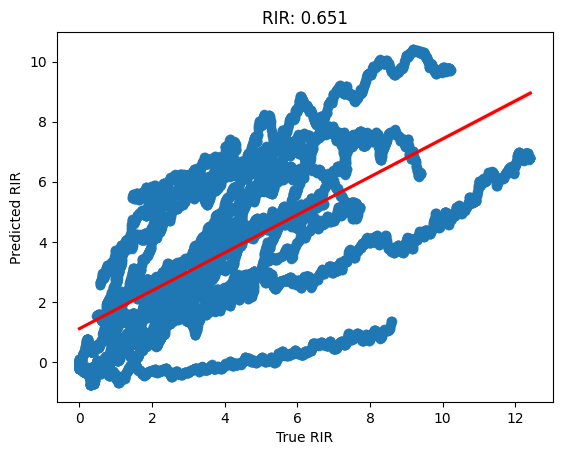

In [54]:
r_value = linregress(ys, ypreds).rvalue
sns.regplot(x=ys, y=ypreds, line_kws={'color': 'red'})
plt.xlabel('True RIR')
plt.ylabel('Predicted RIR')
plt.title(f'RIR: {r_value:.3f}')